# Wavelength calibration test

Based on sky emission lines identified in Row-stacked spectra (RSS)

## 1. Initialisation

### Imports

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors

import numpy as np
import os
import glob

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as c
from astropy.table import Table


### Ancillary data

UVES sky emission atlas: <https://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html>

In [2]:
wave_flux = np.empty((0, 2))
filenames = glob.glob('sky/UVES_sky_emission_atlas/gident_*.dat')
filenames.sort()
for filename in filenames:
    print(filename)
    wave_flux = np.concatenate((wave_flux, np.loadtxt(filename, usecols=(1, 4), skiprows=3, comments=['#', '--------'])), axis=0)
UVES_atlas = Table(wave_flux, names=('wavelength', 'flux'))

sky/UVES_sky_emission_atlas/gident_346.dat
sky/UVES_sky_emission_atlas/gident_437.dat
sky/UVES_sky_emission_atlas/gident_580L.dat
sky/UVES_sky_emission_atlas/gident_580U.dat
sky/UVES_sky_emission_atlas/gident_800U.dat
sky/UVES_sky_emission_atlas/gident_860L.dat
sky/UVES_sky_emission_atlas/gident_860U.dat


## 2. WEAVE RSS files

In [3]:
class WEAVE_RSS(object):
    
    def __init__(self, filename):
        '''Read a WEAVE "single exposure" file (i.e. row-stacked spectra for just one arm)'''
        self.filename = filename
        self.hdu = fits.open(filename)
        wcs = WCS(self.hdu[1].header)
        pixels = np.arange(self.hdu[1].data.shape[1])
        self.wavelength = wcs.spectral.pixel_to_world(pixels).to_value(u.Angstrom)
        self.counts = self.hdu[3].data
        self.counts_error = np.where(self.hdu[4].data > 0, 1/np.sqrt(self.hdu[4].data), np.nan)
        self.sky_counts = self.hdu[3].data - self.hdu[1].data
        self.sensitivity_function = self.hdu[5].data
        self.flux = self.hdu[1].data*self.sensitivity_function
        self.sky_sub_ivar = self.hdu[2].data
        
        bad = np.isnan(self.counts_error).nonzero()
        self.counts[bad] = np.nan
        self.sky_counts[bad] = np.nan
        self.sensitivity_function[bad] = np.nan
        self.flux[bad] = np.nan
        self.sky_sub_ivar[bad] = np.nan
        
        wave = UVES_atlas['wavelength']
        inside = np.where((wave > self.wavelength[0]) & (wave < self.wavelength[-1]))
        self.sky_lines = UVES_atlas[inside]


In [4]:
red_arm = WEAVE_RSS('SV/20230512_13/single_3005695.fit')
blue_arm = WEAVE_RSS('SV/20230512_13/single_3005696.fit')
rss_list = [blue_arm, red_arm]
rss = red_arm

/tmp/ipykernel_125033/544084989.py:11: RuntimeWarning: divide by zero encountered in true_divide
  self.counts_error = np.where(self.hdu[4].data > 0, 1/np.sqrt(self.hdu[4].data), np.nan)
/tmp/ipykernel_125033/544084989.py:11: RuntimeWarning: divide by zero encountered in true_divide
  self.counts_error = np.where(self.hdu[4].data > 0, 1/np.sqrt(self.hdu[4].data), np.nan)


In [5]:
rss.hdu.info()

Filename: SV/20230512_13/single_3005695.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     469   ()      
  1  RED_DATA      1 ImageHDU        72   (7341, 600)   float32   
  2  RED_IVAR      1 ImageHDU        72   (7341, 600)   float32   
  3  RED_DATA_NOSS    1 ImageHDU        72   (7341, 600)   float32   
  4  RED_IVAR_NOSS    1 ImageHDU        72   (7341, 600)   float32   
  5  RED_SENSFUNC    1 ImageHDU        22   (7341, 600)   float32   
  6  FIBTABLE      1 BinTableHDU    181   600R x 60C   [1I, 1I, 20A, 1D, 1D, 1E, 1E, 1A, 30A, 1E, 1E, 15A, 1E, 1I, 30A, 1D, 1D, 1E, 30A, 1E, 1E, 1E, 1A, 40A, 12A, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1D, 1D, 1E, 1E, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   


In [6]:
#rss.hdu[0].header
#rss.sky_lines

### Raw counts and errors

Text(0.5, 0, 'wavelength [$\\AA$]')

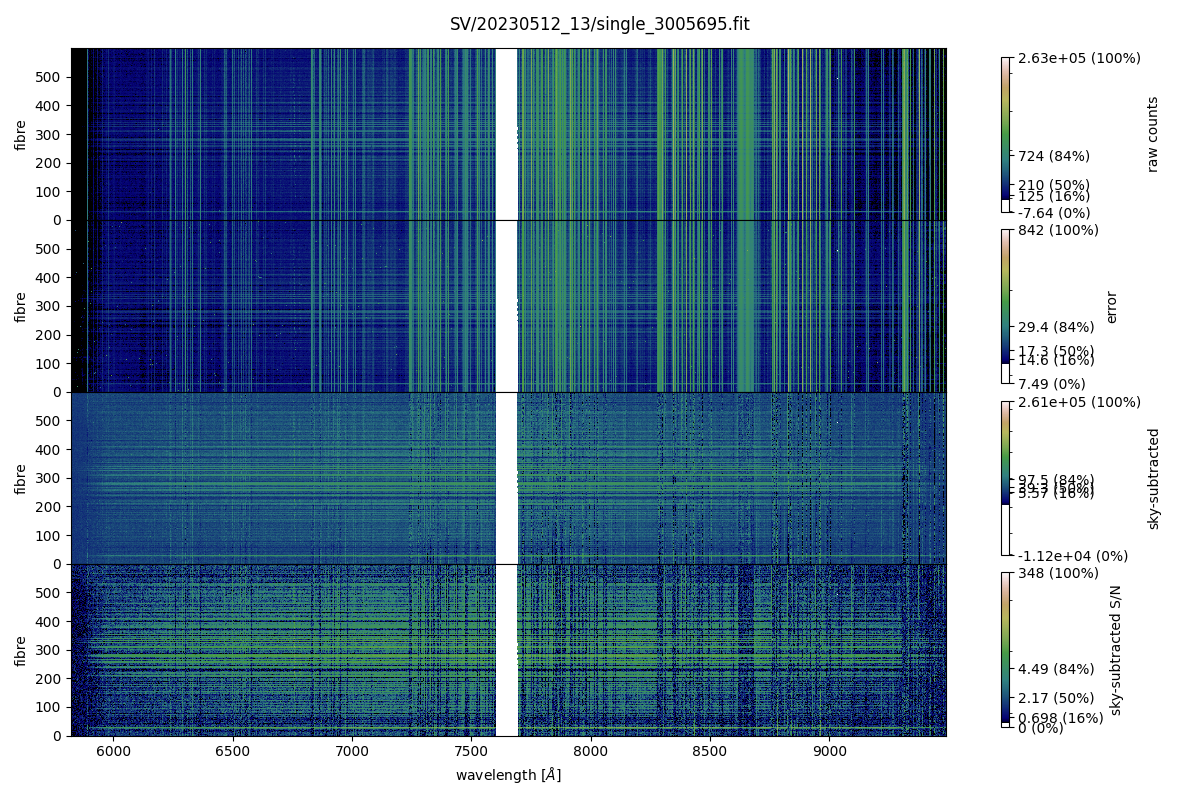

In [35]:
fig_name = 'counts_maps'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=4, ncols=1, squeeze=False,
                    sharex='col', sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)

def show_data(x, data, ax, title, angle=0):
    percentiles = np.array([0, 16, 50, 84, 100])
    ticks = np.nanpercentile(data, percentiles)
    median = ticks[np.argmin(np.abs(percentiles-50))]
    std = np.std(data[data < median])
    im = ax.imshow(data,
                   extent=(x[0], x[-1], -.5, data.shape[0]-.5),
                   interpolation='nearest', origin='lower',
                   #cmap='nipy_spectral',
                   #cmap='terrain',
                   #cmap='gist_stern',
                   #cmap='ocean',
                   cmap='gist_earth',
                   norm=colors.SymLogNorm(vmin=median-3*std, vmax=ticks[-1], linthresh=median+3*std),
                   #norm=colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=median),
                  )
    ax.set_aspect('auto')
    ax.set_ylabel('fibre')
    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(title)
    cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)], rotation=angle)


show_data(rss.wavelength, rss.counts, axes[0, 0], 'raw counts')
show_data(rss.wavelength, rss.counts_error, axes[1, 0], 'error')
show_data(rss.wavelength, rss.counts-rss.sky_counts, axes[2, 0], 'sky-subtracted')
show_data(rss.wavelength, np.abs(rss.counts-rss.sky_counts)/rss.counts_error, axes[3, 0], 'sky-subtracted S/N')
#show_data(rss.wavelength, rss.flux, axes[2, 0], 'flux')

axes[-1, 0].set_xlabel(r'wavelength [$\AA$]')


In [8]:
sorted_counts = np.sort(rss.counts.ravel())
sorted_counts = sorted_counts[np.isfinite(sorted_counts)]
N = sorted_counts.size
y = np.arange(N)
y = (y+1)*(N-y)/N

In [9]:
sorted_err = np.sort(rss.counts_error.ravel())
sorted_err = sorted_err[np.isfinite(sorted_err)]
N_err = sorted_err.size
y_err = np.arange(N_err)
y_err = (y_err+1)*(N_err-y_err)/N_err

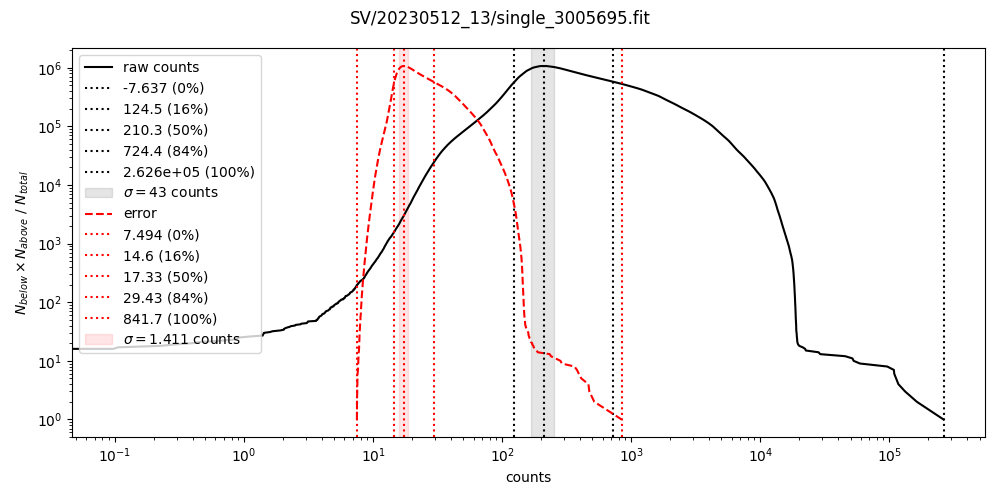

In [36]:
fig_name = 'count_histogram'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(10, 5))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)


ax = axes[0, 0]
ax.set_ylabel(r'$N_{below} \times N_{above} ~/~ N_{total}$')
ax.set_yscale('log')

ax.plot(sorted_counts, y, 'k-', label='raw counts')

percentiles = np.array([0, 16, 50, 84, 100])
for per, val in zip(percentiles, sorted_counts[percentiles*(N-1)//100]):
    ax.axvline(val, color='k', ls=':', label=f'{val:.4g} ({per}%)')

median = sorted_counts[N//2]
std = np.std(sorted_counts[:N//2])
ax.axvspan(median-std, median+std, color='k', alpha=.1, label=f'$\\sigma=${std:.4g} counts')
ax.legend()

ax.plot(sorted_err, y_err, 'r--', label='error')

for per, val in zip(percentiles, sorted_err[percentiles*(N_err-1)//100]):
    ax.axvline(val, color='r', ls=':', label=f'{val:.4g} ({per}%)')

median = sorted_err[N//2]
std = np.std(sorted_err[:N//2])
ax.axvspan(median-std, median+std, color='r', alpha=.1, label=f'$\\sigma=${std:.4g} counts')
ax.legend(loc='upper left')


ax = axes[-1, 0]
ax.set_xlabel(r'counts')
ax.set_xscale('log')


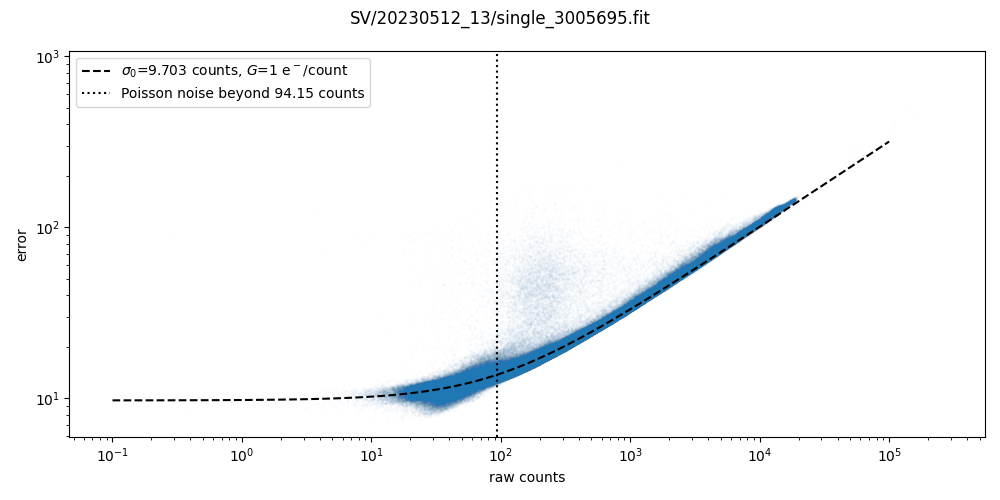

In [37]:
fig_name = 'counts_error'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(10, 5))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)


ax = axes[0, 0]
ax.set_ylabel(r'error')
ax.set_yscale('log')
ax.scatter(rss.counts.flat, rss.counts_error.flat, s=1, alpha=.01)

n_counts = np.logspace(-1, 5, 101)
electrons_per_count = 1  # initial guess
sigma_ron = np.sqrt(np.nanmedian((rss.counts_error**2 - rss.counts*electrons_per_count)))
electrons_per_count = np.sqrt(np.nanmedian((rss.counts_error**2 - sigma_ron**2)/rss.counts))
noise_transition = sigma_ron**2/electrons_per_count
ax.plot(n_counts, np.sqrt(sigma_ron**2 + electrons_per_count*n_counts), 'k--', label=f'$\\sigma_0$={sigma_ron:.4g} counts, $G$={electrons_per_count:.4g} e$^-$/count')
ax.axvline(noise_transition, c='k', ls=':', label=f'Poisson noise beyond {noise_transition:.4g} counts')

ax.legend(loc='upper left')

ax = axes[-1, 0]
ax.set_xlabel(r'raw counts')
ax.set_xscale('log')


## 3. Find sky spectrum

In [38]:
def find_continuum(wavelength, data):
    p16, median = np.nanpercentile(data, [16, 50], axis=0)
    sigma = median - p16
    SN = median/(sigma + 1e-30*np.median(median[median > 0]))
    p16, p84 = np.nanpercentile(SN, [16, 84])
    continuum = np.where((SN > p16) & (SN < p84))

    return median, sigma

sky_blue, std_sky_blue = find_continuum(wavelength_blue, raw_blue)
sky_red, std_sky_red = find_continuum(wavelength_red, raw_red)

NameError: name 'wavelength_blue' is not defined

In [ ]:
fig_name = 'sky_spectrum'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 5))
axes = fig.subplots(nrows=2, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)

ax = axes[0, 0]
ax.set_ylabel('median counts')
ax.set_yscale('log')

ax.plot(wavelength_blue, sky_blue, color='b', alpha=.5)
ax.fill_between(wavelength_blue, sky_blue-std_sky_blue, sky_blue+std_sky_blue, color='b', alpha=.2)
ax.plot(wavelength_red, sky_red, color='r', alpha=.5)
ax.fill_between(wavelength_red, sky_red-std_sky_red, sky_red+std_sky_red, color='r', alpha=.2)
sky_dominated_red = np.where(std_sky_red < 0.1*sky_red)
ax.plot(wavelength_red[sky_dominated_red], sky_red[sky_dominated_red], 'k+', alpha=.5)

ax = axes[1, 0]
ax.set_ylabel('std/median')
ax.set_yscale('log')

ax.plot(wavelength_blue, std_sky_blue/sky_blue, 'b-', alpha=.5)
ax.plot(wavelength_red, std_sky_red/sky_red, 'r-', alpha=.5)
ax.axhline(.1, c='k', ls=':', alpha=.5)

ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')

#for ax in axes.flat:
#    for line in skyline_wave_red:
#        ax.axvline(line, c='c', alpha=.05)
#    #ax.plot(skyline_wave, skyline_flux, 'k.')


### Line Spread Function

In [ ]:
def fit_Gaussian(x, I):
    peak = np.nanmax(I)
    if np.isnan(peak):
        return np.nan, np.nan, np.nan, np.nan
    background = np.nanmin(I)
    mean_intensity = np.nanmean(I-background)
    mean_x = np.nanmean((I-background)*x)/mean_intensity
    sigma_x = np.sqrt(np.nanmean((I-background)*(x-mean_x)**2)/mean_intensity)

    x_min = x[np.nanargmin(I)]
    correction = np.exp(-.5*(x_min-mean_x)**2/sigma_x**2)
    line_flux = (peak-background)*np.sqrt(2*np.pi)*sigma_x/(1-correction)
    background = peak - line_flux/np.sqrt(2*np.pi)/sigma_x
    
    return background, line_flux, mean_x, sigma_x


In [ ]:
fig_name = 'sky_line_profiles'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(6, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
for ax in axes.flat:
    ax.grid(True, alpha=.1)
fig.set_tight_layout(True)

ax = axes[0, 0]
ax.set_title('Sky line profile (LSF)')
ax.set_ylabel('normalised median counts')
#ax.set_yscale('log')
ax.set_xlabel(r'$\Delta v$ [km/s]')

def normalise(x):
    x -= np.median(x)
    norm = x[x.size//2]
    if norm > 0:
        x /= norm
    else:
        x *= np.nan
    return x

ax = axes[0, 0]
delta_v = np.linspace(-500, 500, 201)
sky = np.nanmedian(raw_red, axis=0)
median_skyline = np.zeros((skyline_wave_red.size, delta_v.size))
for i, line in enumerate(skyline_wave_red):
    l = (1+delta_v/3e5)*line
    sed = np.interp(l, wavelength_red, sky)
    sed = normalise(sed)
    median_skyline[i] = sed
    ax.plot(delta_v, sed, 'c-', alpha=.05)

median_skyline = normalise(np.nanmedian(median_skyline, axis=0))
ax.plot(delta_v, median_skyline, 'k-')
ax.set_ylim(1.1*np.min(median_skyline), 1.1*np.max(median_skyline))

background = np.median(median_skyline)
line_left = np.max(delta_v[(delta_v < 0) & (median_skyline <= background)])
line_right = np.min(delta_v[(delta_v > 0) & (median_skyline <= background)])
ax.axvspan(line_left, line_right, color='k', alpha=.2)

narrow_profile = np.where((delta_v > line_left) & (delta_v < line_right))
delta_v = delta_v[narrow_profile]
median_skyline = median_skyline[narrow_profile]
background, line_flux, mean_v, sigma_v = fit_Gaussian(delta_v, median_skyline)

margin = (line_right-line_left)/4
x = np.linspace(line_left-margin, line_right+margin, delta_v.size*4)
ax.axvline(mean_v, c='b', ls=':', label=f'$\langle\Delta v\\rangle$ = {mean_v:.1f} km/s')
ax.plot(x, background+line_flux/np.sqrt(2*np.pi)/sigma_v*np.exp(-.5*((x-mean_v)/sigma_v)**2), 'b-', label=f'$\sigma_v$ = {sigma_v:.1f} km/s')
ax.axhline(background, c='b', ls=':', label=f'background = {background:.2f} counts')

ax.legend()

### Emission lines

In [ ]:
def total_line_emission(wavelength, skyline_wave, skyline_flux, skyline_scale):
    total_lines = np.zeros_like(wavelength)
    for (line, flux, scale) in zip(skyline_wave, skyline_flux, skyline_scale):
        lam = (1+delta_v/3e5)*line
        median_skyline_flux = np.nanmean(median_skyline)*(lam[-1]-lam[0])
        norm = flux*scale/median_skyline_flux
        if norm > 0:
            total_lines += norm * np.interp(wavelength, lam, median_skyline, left=0, right=0)
    return total_lines


# initial scale factor, assuming zero sky continuum

skyline_scale_red = np.ones_like(skyline_wave_red)
scale_factor = sky_red / total_line_emission(wavelength_red, skyline_wave_red, skyline_flux_red, skyline_scale_red)
for i, line in enumerate(skyline_wave_red):
    lam = (1+delta_v/3e5)*line
    skyline_scale_red[i] = np.nanmin(np.interp(lam, wavelength_red, scale_factor)).clip(min=0)

total_lines_red = total_line_emission(wavelength_red, skyline_wave_red, skyline_flux_red, skyline_scale_red)


def find_continuum(wavelength, sky_spectrum, line_emission):
    sky_continuum = sky_spectrum - line_emission
    good_continuum = np.where(sky_continuum > line_emission)
    sky_continuum = np.interp(wavelength, wavelength[good_continuum], sky_continuum[good_continuum])
    sky_continuum = np.fmin(sky_continuum, sky_spectrum)

    bin_size = 20
    #bin_left = np.arange(0, wavelength.size-bin_size, bin_size)
    #bin_wavelength = wavelength[bin_left+bin_size//2]
    #bin_continuum = np.zeros_like(bin_wavelength)
    #for i, left in enumerate(bin_left):
    #    bin_continuum[i] = np.nanmin(sky_continuum[left:left+bin_size])
    #sky_continuum = np.interp(wavelength, bin_wavelength, bin_continuum)
    bin_size *= 2
    bin_left = np.arange(0, wavelength.size-bin_size, bin_size)
    bin_wavelength = wavelength[bin_left+bin_size//2]
    bin_continuum = np.zeros_like(bin_wavelength)
    for i, left in enumerate(bin_left):
        bin_continuum[i] += np.nanmean(sky_continuum[left:left+bin_size])
        #bin_continuum[i] += np.nanmedian(sky_continuum[left:left+bin_size])
        #bin_continuum[i] += np.nanmin(sky_continuum[left:left+bin_size])
        #bin_continuum[i] /= 3
    sky_continuum = np.interp(wavelength, bin_wavelength, bin_continuum)
    sky_continuum = np.fmin(sky_continuum, sky_spectrum)

    return sky_continuum


# Iteratively refine sky line+continuum estimates

old_residual = np.inf
new_residual = np.nanmax(sky_red)
while new_residual < .999*old_residual:
    old_residual = new_residual

    sky_continuum_red = find_continuum(wavelength_red, sky_red, total_lines_red)

    epsilon = 1e-30*np.min(std_sky_red)
    rescale_factor = (sky_red - sky_continuum_red)/(total_lines_red + epsilon)
    #skyline_scale_red *= np.interp(skyline_wave_red, wavelength_red, rescale_factor).clip(min=0.5, max=2.)
    #for i, line in enumerate(skyline_wave_red):
    #    lam = (1+delta_v/3e5)*line
    #    skyline_scale_red[i] *= np.nanmean(np.interp(lam, wavelength_red, rescale_factor)).clip(min=0, max=2)
    for (line, flux, scale) in zip(skyline_wave_red, skyline_flux_red, skyline_scale_red):
        lam = (1+delta_v/3e5)*line
        median_skyline_flux = np.nanmean(median_skyline)*(lam[-1]-lam[0])
        norm = flux*scale/median_skyline_flux
        norm = 1/median_skyline_flux
        if norm > 0:
            factor = np.nanmean(np.interp(lam, wavelength_red, rescale_factor)
                                        * norm * median_skyline
                                        / 1)*(lam[-1]-lam[0]) #np.interp(lam, wavelength_red, total_lines_red)
            print(line, factor, flux*scale/factor, np.interp(line, wavelength_red, rescale_factor))
            skyline_scale_red *= np.clip(factor, .5, 2.)
    total_lines_red = total_line_emission(wavelength_red, skyline_wave_red, skyline_flux_red, skyline_scale_red)

    residual = (sky_red - (sky_continuum_red+total_lines_red)) / std_sky_red
    p16, p50, p84 = np.nanpercentile(residual, [16, 50, 84])
    new_residual = p84-p16
    print(np.nanmean(residual), np.nanstd(residual), [p16, p50, p84], p84-p16, new_residual/old_residual)

skyline_ew_red = skyline_flux_red*skyline_scale_red / np.interp(skyline_wave_red, wavelength_red, sky_continuum_red)
strong_lines = np.where(skyline_ew_red > 3)

In [ ]:
def running_median(x, y, bin_size):
    bin_left = np.arange(0, x.size-bin_size, bin_size)
    bin_x = x[bin_left+bin_size//2]
    bin_y = np.zeros_like(bin_x)
    for i, left in enumerate(bin_left):
        bin_y[i] = np.nanmedian(y[left:left+bin_size])
        #bin_y[i] = np.nanmean(y[left:left+bin_size])

    return np.interp(x, bin_x, bin_y)

sky_scale_red = np.interp(wavelength_red, skyline_wave_red[strong_lines], skyline_scale_red[strong_lines])
sky_scale_red_smooth = running_median(wavelength_red, sky_scale_red, 100)

In [ ]:
fig_name = 'sky_continuum'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 4))
axes = fig.subplots(nrows=2, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
for ax in axes.flat:
    ax.grid(True, alpha=.1)
fig.set_tight_layout(True)


ax = axes[0, 0]
ax.set_ylabel('intensity I')
ax.set_yscale('log')

ax.plot(wavelength_red, sky_red, color='r', alpha=.5)
ax.fill_between(wavelength_red, sky_red-std_sky_red, sky_red+std_sky_red, color='r', alpha=.2)
for line in skyline_wave_red:
    ax.axvline(line, c='c', alpha=.05)
for line in skyline_wave_red[strong_lines]:
    ax.axvline(line, c='k', ls=':', alpha=.5)

ax.plot(wavelength_red, sky_continuum_red, 'g-', alpha=.5)
ax.plot(wavelength_red, sky_continuum_red+total_lines_red, 'k-', alpha=1)

ax = axes[1, 0]
ax.set_ylabel('scale factor')
ax.set_yscale('log')
ax.plot(wavelength_red, 1e-16/sensitivity_function_red[0], 'r-', alpha=1)

#ax.plot(wavelength_red, rescale_factor, 'g-', alpha=.25)
ax.plot(skyline_wave_red, np.interp(skyline_wave_red, wavelength_red, rescale_factor), 'g.', alpha=.5)
#ax.set_ylim(.5, 2.5)
ax.plot(skyline_wave_red, skyline_scale_red, 'k+', alpha=.2)
ax.plot(skyline_wave_red[strong_lines], skyline_scale_red[strong_lines], 'kx:', alpha=.25)
#ax.plot(wavelength_red, sky_scale_red, 'r-', alpha=1)
ax.plot(wavelength_red, sky_scale_red_smooth, 'r--', alpha=1)
ax.set_ylim(.1, 1e4)

ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')
#ax.set_xlim(6100, 6400)
#ax.set_xlim(9300, 9400)
#ax.set_xlim(6250, 6350)

In [ ]:
np.nanpercentile(skyline_ew_red, [16, 50, 84])

In [ ]:
'''
skyline_scale_red = np.ones_like(skyline_wave_red)
skyline_continuum_red = np.ones_like(skyline_wave_red)
sky_continuum_red = np.zeros_like(sky_red)
def total_line_emission():
    total_lines_red = np.zeros_like(wavelength_red)
    for (line, flux, scale) in zip(skyline_wave_red, skyline_flux_red, skyline_scale_red):
        lam = (1+delta_v/3e5)*line
        median_skyline_flux = np.mean(median_skyline)*(lam[-1]-lam[0])
        total_lines_red += np.interp(wavelength_red, lam, median_skyline, left=0, right=0)*flux*scale/median_skyline_flux
    return total_lines_red
'''


fig_name = 'sky_continuum_2'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 4))
axes = fig.subplots(nrows=2, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
for ax in axes.flat:
    ax.grid(True, alpha=.1)
fig.set_tight_layout(True)

ax = axes[0, 0]
ax.set_ylabel('intensity I')
ax.set_yscale('log')

ax.plot(wavelength_red, sky_red, color='r', alpha=.5)
ax.fill_between(wavelength_red, sky_red-std_sky_red, sky_red+std_sky_red, color='r', alpha=.2)
#ax.plot(wavelength_red, total_line_emission(), 'g:', alpha=.5)


scale_factor = (sky_red - sky_continuum_red)/total_line_emission()
skyline_scale_red *= np.interp(skyline_wave_red, wavelength_red, scale_factor).clip(min=0)
line_emission = total_line_emission().clip(min=0)
'''
sky_continuum_red = sky_red - line_emission
good_continuum = np.where(sky_continuum_red > line_emission)
sky_continuum_red = np.interp(wavelength_red, wavelength_red[good_continuum], sky_continuum_red[good_continuum])
sky_continuum_red = np.fmin(sky_continuum_red, sky_red)
for i, line in enumerate(skyline_wave_red):
    lam = (1+delta_v/3e5)*line
    skyline_continuum_red[i] = np.nanmin(np.interp(lam, wavelength_red, sky_continuum_red)).clip(min=0)

bin_size = 20
bin_left = np.arange(0, wavelength_red.size-bin_size, bin_size)
bin_wavelength = wavelength_red[bin_left+bin_size//2]
bin_continuum = np.zeros_like(bin_wavelength)
for i, left in enumerate(bin_left):
    bin_continuum[i] = np.nanmin(sky_continuum_red[left:left+bin_size])
sky_continuum_red = np.interp(wavelength_red, bin_wavelength, bin_continuum)
for i, left in enumerate(bin_left):
    bin_continuum[i] = np.nanmedian(sky_continuum_red[left:left+bin_size])
sky_continuum_red = np.interp(wavelength_red, bin_wavelength, bin_continuum)
'''

'''
continuum_weight = (sky_continuum_red/sky_red).clip(min=0, max=1)
integral_model = np.nancumsum(sky_continuum_red*continuum_weight)
integral_weight = np.nancumsum(continuum_weight)
smoothing_weight = (delta_v[-1] - delta_v[0])/3e5 * np.nanmean(wavelength_red[1:]/np.diff(wavelength_red))
w0 = (integral_weight - smoothing_weight).clip(min=integral_weight[0])
w1 = (integral_weight + smoothing_weight).clip(max=integral_weight[-1])
sky_continuum_red += (np.interp(w1, integral_weight, integral_model) - np.interp(w0, integral_weight, integral_model)) / (w1 - w0)
sky_continuum_red = np.fmin(sky_continuum_red/2, sky_red)
'''


ax.plot(wavelength_red, line_emission, 'k-', alpha=.1)
ax.plot(wavelength_red, sky_continuum_red, 'g-', alpha=.5)
ax.plot(wavelength_red, sky_continuum_red+line_emission, 'k-', alpha=1)
#ax.plot(skyline_wave_red, skyline_continuum_red, 'g+', alpha=1)
#ax.plot(bin_wavelength, bin_continuum, 'r--', alpha=.5)

ax = axes[1, 0]
ax.set_ylabel('scale factor')
ax.set_yscale('log')
ax.plot(wavelength_red, scale_factor, 'g-', alpha=.2)
ax.plot(skyline_wave_red, skyline_scale_red, 'k+', alpha=1)


ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')
ax.set_xlim(6100, 6400)

In [ ]:
np.min(skyline_flux_red), np.min(skyline_scale_red) > 0

In [ ]:
total_line_emission()

### Old fit

In [ ]:
new_model = np.zeros((skyline_wave.size, 4))
new_model[:, 1] = skyline_flux
new_model[:, 2] = skyline_wave
new_model[:, 3] = skyline_wave*sigma_v/3e5

new_line_weight_red = np.zeros_like(wavelength_red)
for i in range(skyline_wave.size):
    line_profile = new_model[i, 1]*np.exp(-.5*((wavelength_red-new_model[i, 2])/new_model[i, 3])**2)/np.sqrt(2*np.pi)/new_model[i, 3]
    new_line_weight_red += line_profile
new_line_weight_red += 1e-30*np.nanmean(new_line_weight_red[new_line_weight_red > 0])

new_background_model_red = np.zeros_like(wavelength_red)


In [ ]:
old_chi2 = np.inf
lam0, lam1 = np.searchsorted(wavelength_red, [skyline_wave[0], skyline_wave[-1]])
std_sky_red += 1e-30*np.mean(std_sky_red[std_sky_red > 0])
chi2 = np.std(sky_red[lam0:lam1]/std_sky_red[lam0:lam1])*1e30
print(chi2)

while chi2 < old_chi2:
    model = new_model.copy()
    total_line_weight_red = new_line_weight_red.copy()
    background_model_red = new_background_model_red.copy()
    old_chi2 = chi2
    new_line_weight_red = np.zeros_like(wavelength_red)
    new_background_model_red = np.zeros_like(wavelength_red)

    for i, line in enumerate(skyline_wave):
        lam = (1+delta_v/3e5)*line
        sky = np.interp(lam, wavelength_red, (sky_red-background_model_red)/total_line_weight_red)
        sky *= model[i, 1]*np.exp(-.5*((lam-model[i, 2])/model[i, 3])**2)/np.sqrt(2*np.pi)/model[i, 3]

        new_model[i] = fit_Gaussian(lam, sky)
        if np.isfinite(new_model[i, 1]):
            line_profile = new_model[i, 1]*np.exp(-.5*((wavelength_red-new_model[i, 2])/new_model[i, 3])**2)/np.sqrt(2*np.pi)/new_model[i, 3]

            new_line_weight_red += line_profile
            new_model[i, 0] += np.interp(new_model[i, 2], wavelength_red, background_model_red)
            #new_background_model_red += max(model[i, 0], 0) * line_profile
            new_background_model_red += new_model[i, 0] * line_profile
        else:
            #print(f'nan at {line:.1f} AA: {model[i]}')
            new_model[i] = np.zeros_like(model[i])
    new_line_weight_red += 1e-30*np.nanmean(new_line_weight_red[new_line_weight_red > 0])

    w = sky_red/(sky_red+new_line_weight_red)
    new_background_model_red = w*(sky_red-new_line_weight_red) + (1-w)*new_background_model_red/new_line_weight_red
    integral_model = np.cumsum(new_background_model_red*w)
    integral_w = np.cumsum(w)
    w_smooth = delta_v.size*2
    w0 = (integral_w - w_smooth).clip(min=integral_w[0])
    w1 = (integral_w + w_smooth).clip(max=integral_w[-1])
    new_background_model_red = (np.interp(w1, integral_w, integral_model) - np.interp(w0, integral_w, integral_model)) / (w1 - w0)

    chi2 = np.nanstd((sky_red[lam0:lam1] - new_background_model_red[lam0:lam1] - new_line_weight_red[lam0:lam1]) / std_sky_red[lam0:lam1])
    print(chi2)

chi2 = np.std((sky_red[lam0:lam1] - background_model_red[lam0:lam1] - total_line_weight_red[lam0:lam1]) / std_sky_red[lam0:lam1])
print(chi2)


In [ ]:
fig_name = 'sky_line_fit'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 8))
axes = fig.subplots(nrows=4, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
for ax in axes.flat:
    ax.grid(True, alpha=.1)
fig.set_tight_layout(True)

ax = axes[0, 0]
ax.set_ylabel('counts')
ax.set_yscale('log')
ax.set_ylim(.1, 1e5)

sky_blue, std_sky_blue = find_continuum(wavelength_blue, raw_blue, ax, 'b')
sky_red, std_sky_red = find_continuum(wavelength_red, raw_red, ax, 'r')

for i, line in enumerate(skyline_wave):
    lam = (1+delta_v/3e5)*line
    ax.plot(lam,
            model[i, 0] + model[i, 1]*np.exp(-.5*((lam-model[i, 2])/model[i, 3])**2)/np.sqrt(2*np.pi)/model[i, 3],
            'k-', alpha=.1)

ax.plot(wavelength_red, background_model_red, 'g-', alpha=.5)
ax.plot(wavelength_red, background_model_red+total_line_weight_red, 'k--', alpha=.5)


ax = axes[1, 0]
ax.set_ylabel('counts / initial flux')
ax.set_yscale('log')

for i, line in enumerate(skyline_wave):
    ax.plot(line, model[i, 1]/skyline_flux[i], 'k+')

y = model[:, 1]/skyline_flux
p16, p50, p84 = np.nanpercentile(y, [16, 50, 84])
y_min = p50*(p16/p50)**3
y_max = p50*(p84/p50)**3
#good = (y > y_min) & (y < y_max)
ax.axhspan(p16, p84, label=f'{p50:.3g} +- ({p84:.3g}, {p16:.3g})', color='green', alpha=.2)
ax.axhline(y_max, color='green', alpha=.2, ls='--')
ax.axhline(y_min, color='green', alpha=.2, ls='--')
ax.legend()
#ax.set_ylim(.5*y_min, 1.5*y_max)


ax = axes[2, 0]
ax.set_ylabel(r'$\Delta\lambda$ [$\AA$]')
#ax.set_yscale('log')
#ax.set_ylim(-100, 100)

for i, line in enumerate(skyline_wave):
    ax.plot(line, model[i, 2]-line, 'k+')

y = model[:, 2]-skyline_wave
p16, p50, p84 = np.nanpercentile(y, [16, 50, 84])
y_min = p50 - 3*(p50-p16)
y_max = p50 + 3*(p84-p50)
#good &= (y > y_min) & (y < y_max)
ax.axhspan(p16, p84, label=f'{p50:.3g} +- ({p84:.3g}, {p16:.3g})', color='green', alpha=.2)
ax.axhline(y_max, color='green', alpha=.2, ls='--')
ax.axhline(y_min, color='green', alpha=.2, ls='--')
ax.legend()
margin = .5*(y_max-y_min)
#ax.set_ylim(y_min-margin, y_max+margin)
ax.set_ylim(-5, 5)
ax.plot(wavelength_red, (sky_red - background_model_red - total_line_weight_red) / std_sky_red, 'k--')


ax = axes[3, 0]
ax.set_ylabel(r'$\sigma_\lambda$ [$\AA$]')
#ax.set_yscale('log')
#ax.set_ylim(-100, 100)

for i, line in enumerate(skyline_wave):
    ax.plot(line, model[i, 3], 'k+')

y = model[:, 3]
p16, p50, p84 = np.nanpercentile(y, [16, 50, 84])
y_min = p50 - 3*(p50-p16)
y_max = p50 + 3*(p84-p50)
#good &= (y > y_min) & (y < y_max)
ax.axhspan(p16, p84, label=f'{p50:.3g} +- ({p84:.3g}, {p16:.3g})', color='green', alpha=.2)
ax.axhline(y_max, color='green', alpha=.2, ls='--')
ax.axhline(y_min, color='green', alpha=.2, ls='--')
ax.legend()
margin = .5*(y_max-y_min)
ax.set_ylim(y_min-margin, y_max+margin)

ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')
ax.set_xlim(skyline_wave[0], skyline_wave[-1])
#ax.set_xlim(6200, 6400)
#ax.set_xlim(6500, 6600)
#ax.set_xlim(5800, 5900)


In [ ]:
delta_v.size

In [ ]:
mean_counts_red = np.nanmean(hdu_red[1].data, axis=0)  # same as hdu[6]
mean_sky_map_red = np.nanmean(hdu_red[3].data-hdu_red[1].data, axis=0)

mask_bright = mean_counts_red > mean_sky_map_red
mask_faint = (mean_counts_red > 0) & (mean_counts_red <= mean_sky_map_red)
mask_all = mean_counts_red > 0

In [ ]:
plt.close('counts')
fig = plt.figure('counts', figsize=(6, 4))
ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                  sharex=True, sharey=True,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)


def show_data(data, ax, title):
    p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
    im = ax.imshow(data,
                   interpolation='nearest', origin='lower',
                   cmap='nipy_spectral',
                   norm=colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=p50-p0),
                  )
    ax.contour(mask_faint, levels=[0.5], colors=['w'])
    cb = fig.colorbar(im, ax=ax, orientation='horizontal')
    cb.ax.set_title(title)
    cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)

show_data(mean_counts_red, ax[0, 0], 'Mean counts')
show_data(mean_sky_map_red, ax[0, 1], 'Mean sky')

plt.show()

### broadband colors:

In [ ]:
class Filter(object):
    
    def __init__(self, filename, col_wavelength=0, col_response=1):
        self.wavelength, self.response = np.loadtxt(filename, usecols=(col_wavelength, col_response), unpack=True)        
        #self.norm_AB =  np.trapz(3631/3.34e4 * self.response/self.wavelength, self.wavelength)
        self.pivot_wavelength =  np.sqrt(
            np.trapz(self.response, self.wavelength) / np.trapz(self.response/self.wavelength**2, self.wavelength))
        
    def m_AB(self, wavelength, F_lambda):
        """F_lambda in erg/s/cm^2/AA"""
        response = np.interp(wavelength, self.wavelength, self.response)
        return -2.5*np.log10(
            np.trapz(wavelength*F_lambda*response, wavelength) / np.trapz(3631/3.34e4 * response/wavelength, wavelength))

    def m_AB_cube(self, wavelength, F_lambda_cube):
        """F_lambda in erg/s/cm^2/AA"""
        response = np.interp(wavelength, self.wavelength, self.response)
        return -2.5*np.log10(
            np.trapz(F_lambda_cube*(wavelength*response)[:, np.newaxis, np.newaxis], wavelength, axis=0) / np.trapz(3631/3.34e4 * response/wavelength, wavelength))

g_filter = Filter('sdss-filters/g.dat', 0, 2)
r_filter = Filter('sdss-filters/r.dat', 0, 2)
i_filter = Filter('sdss-filters/i.dat', 0, 2)
z_filter = Filter('sdss-filters/z.dat', 0, 2)

### average SED within each region and broadband maps:

In [ ]:
datacube = (hdu_red[3].data - hdu_red[1].data) * sensitivity_function_red[:, np.newaxis, np.newaxis]
sky_red = np.sum(datacube*mask_all[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all)
datacube = (hdu_blue[3].data - hdu_blue[1].data) * sensitivity_function_blue[:, np.newaxis, np.newaxis]
sky_blue = np.sum(datacube*mask_all[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all)


In [ ]:
LIFU_FIBRE_RADIUS = 1.305  # arcsec (2.6 arcsec diameter)
LIFU_FIBRE_AREA = np.pi*LIFU_FIBRE_RADIUS**2
datacube = hdu_red[1].data * sensitivity_function_red[:, np.newaxis, np.newaxis] / LIFU_FIBRE_AREA
SED_bright_red = np.sum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
SED_faint_red = np.sum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)
r_map = r_filter.m_AB_cube(wavelength_red, datacube)
i_map = i_filter.m_AB_cube(wavelength_red, datacube)
z_map = z_filter.m_AB_cube(wavelength_red, datacube)

In [ ]:
datacube = hdu_blue[1].data * sensitivity_function_blue[:, np.newaxis, np.newaxis] / LIFU_FIBRE_AREA
SED_bright_blue = np.sum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
SED_faint_blue = np.sum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)
g_map = g_filter.m_AB_cube(wavelength_blue, datacube)


In [ ]:
def show_data(data, ax, title, cmap, vmin, vmax, projection):
    im = ax.imshow(data,
                   interpolation='nearest', origin='lower',
                   cmap=cmap, vmin=vmin, vmax=vmax,
                  )
    ax.contour(mask_bright, levels=[0.5], colors=['w'])
    cb = fig.colorbar(im, ax=ax, orientation='horizontal')
    cb.ax.set_title(title)
    #cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)


In [ ]:
fig_name = 'broadband_SED'
plt.close(fig_name)
nrows = 2
ncols = 4.1
margin1 = .1
margin2 = .05
L = 1-margin2-margin1
dx = L/ncols
dy = L/nrows
panel_size = 3
fig = plt.figure(fig_name, figsize=(panel_size*ncols, panel_size*nrows))

def init_axis(x, y, wcs):
    ax = fig.add_axes([margin1+x*dx, margin1+y*dy, dx, dy], projection=wcs,
                      sharex=ax0, sharey=ax0
                     )
    ax. grid(True, alpha=.5)
    if(y > 0):
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[0].set_ticklabel_visible(False)
    if(x > 0):
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[1].set_ticklabel_visible(False)
    return ax


y = 1
mag_min = 17
mag_max = 25

ax0 = fig.add_axes([margin1, margin1+y*dy, dx, dy], projection=wcs_blue.celestial)
ax = ax0
ax. grid(True, alpha=.5)
im = ax.imshow(g_map,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(1, y, wcs_red.celestial)
im = ax.imshow(r_map,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(2, y, wcs_red.celestial)
im = ax.imshow(i_map,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(3, y, wcs_red.celestial)
im = ax.imshow(z_map,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = fig.add_axes([margin1+4*dx, margin1+y*dy, .1*dx, dy])
cb = fig.colorbar(im, cax=ax, orientation='vertical')
ax.set_ylim(mag_max, mag_min)

y = 0
color_min = -.1
color_max = 1.1

ax = init_axis(0, y, wcs_red.celestial)
im = ax.imshow(g_map-r_map,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(1, y, wcs_red.celestial)
im = ax.imshow(r_map-i_map,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(2, y, wcs_red.celestial)
im = ax.imshow(i_map-z_map,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(3, y, wcs_red.celestial)
im = ax.imshow(r_map-z_map,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = fig.add_axes([margin1+4*dx, margin1+y*dy, .1*dx, dy])
cb = fig.colorbar(im, cax=ax, orientation='vertical')


plt.tight_layout()

In [ ]:
fig_name = 'broadband_PS1'
plt.close(fig_name)
nrows = 2
ncols = 4.1
margin1 = .1
margin2 = .05
L = 1-margin2-margin1
dx = L/ncols
dy = L/nrows
panel_size = 3
fig = plt.figure(fig_name, figsize=(panel_size*ncols, panel_size*nrows))

xmin, xmax = ax0.get_xlim()
ymin, ymax = ax0.get_ylim()
print(xmin, xmax, ymin, ymax)
bottom_left = wcs_red.celestial.pixel_to_world(xmin, ymin)
top_right = wcs_red.celestial.pixel_to_world(xmax, ymax)
print(bottom_left.ra, top_right.ra, bottom_left.dec, top_right.dec)
xmin, ymin = wcs_r.world_to_pixel_values(bottom_left.ra, bottom_left.dec)
xmax, ymax = wcs_r.world_to_pixel_values(top_right.ra, top_right.dec)
print(xmin, xmax, ymin, ymax)

def init_axis(x, y, wcs):
    ax = fig.add_axes([margin1+x*dx, margin1+y*dy, dx, dy], projection=wcs,
                      sharex=ax1, sharey=ax1
                     )
    ax. grid(True, alpha=.5)
    if(y > 0):
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[0].set_ticklabel_visible(False)
    if(x > 0):
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[1].set_ticklabel_visible(False)
    #ax.set_xlabel(' ')
    #ax.set_ylabel(' ')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    return ax


y = 1
#mag_min = 15.5
#mag_max = 25.5

ax1 = fig.add_axes([margin1, margin1+y*dy, dx, dy], projection=wcs_g)
ax = ax1
ax. grid(True, alpha=.5)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
im = ax.imshow(PS1_g,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(1, y, wcs_r)
im = ax.imshow(PS1_r,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(2, y, wcs_i)
im = ax.imshow(PS1_i,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(3, y, wcs_z)
im = ax.imshow(PS1_z,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = fig.add_axes([margin1+4*dx, margin1+y*dy, .1*dx, dy])
cb = fig.colorbar(im, cax=ax, orientation='vertical')


y = 0
#color_min = .1
#color_max = .9

ax = init_axis(0, y, wcs_r)
im = ax.imshow(PS1_g-PS1_r,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(1, y, wcs_r)
im = ax.imshow(PS1_r-PS1_i,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(2, y, wcs_r)
im = ax.imshow(PS1_i-PS1_z,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(3, y, wcs_r)
im = ax.imshow(PS1_r-PS1_z,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = fig.add_axes([margin1+4*dx, margin1+y*dy, .1*dx, dy])
cb = fig.colorbar(im, cax=ax, orientation='vertical')


plt.tight_layout()

## 3. Spectrophotometric calibration:
### Compute correction:

In [ ]:

def find_continuum(x, y, n=1):
    peaks = np.where(y > 0); xx, yy = x[peaks], y[peaks]
    peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
    xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
    while n > 1:
        peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
        xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
        n -=1
    return xx, yy

wavelength_blue_continuum, sky_blue_continuum = find_continuum(wavelength_blue, sky_blue, 3);
wavelength_red_continuum, sky_red_continuum = find_continuum(wavelength_red, sky_red, 3);
wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum = find_continuum(wavelength_SkyCalc, intensity_SkyCalc, 2);
correction_blue = intensity_SkyCalc_continuum / np.interp(wavelength_SkyCalc_continuum, wavelength_blue_continuum, sky_blue_continuum)
correction_blue = np.interp(wavelength_blue, wavelength_SkyCalc_continuum, correction_blue)
correction_blue /= np.median(correction_blue)
correction_red = intensity_SkyCalc_continuum / np.interp(wavelength_SkyCalc_continuum, wavelength_red_continuum, sky_red_continuum)
correction_red = np.interp(wavelength_red, wavelength_SkyCalc_continuum, correction_red)
correction_red /= np.median(correction_red)


In [ ]:
g_bright = g_filter.m_AB(wavelength_blue, SED_bright_blue)
r_bright = r_filter.m_AB(wavelength_red, SED_bright_red)
i_bright = i_filter.m_AB(wavelength_red, SED_bright_red)
z_bright = z_filter.m_AB(wavelength_red, SED_bright_red)
g_faint = g_filter.m_AB(wavelength_blue, SED_faint_blue)
r_faint = r_filter.m_AB(wavelength_red, SED_faint_red)
i_faint = i_filter.m_AB(wavelength_red, SED_faint_red)
z_faint = z_filter.m_AB(wavelength_red, SED_faint_red)
g_sky = g_filter.m_AB(wavelength_blue, sky_blue)
r_sky = r_filter.m_AB(wavelength_red, sky_red)
i_sky = i_filter.m_AB(wavelength_red, sky_red)
z_sky = z_filter.m_AB(wavelength_red, sky_red)


In [ ]:
lines = {}
lines['OII_3726'] = [3726.032, 3717.0, 3737.0]
lines['OII_3729'] = [3728.815, 3717.0, 3737.0]
lines['NeIII_3869'] = [3869.060, 3859.0, 3879.0]
lines['H_delta'] = [4101.734, 4092.0, 4111.0]
lines['H_gamma'] = [4340.464, 4330.0, 4350.0]
lines['OIII_4363'] = [4363.210, 4350.0, 4378.0]
lines['H_beta'] = [4861.325, 4851.0, 4871.0]
lines['OIII_4959'] = [4958.911, 4949.0, 4969.0]
lines['OIII_5007'] = [5006.843, 4997.0, 5017.0]
lines['HeI_5876'] = [5875.67, 5866.0, 5886.0]
lines['OI_6300'] = [6300.304, 6290.0, 6310.0]
lines['NII_6548'] = [6548.040, 6533.0, 6553.0]
lines['H_alpha'] = [6562.800, 6550., 6575., 6470., 6530., 6600., 6660.]
lines['NII_6584'] = [6583.460, 6573.0, 6593.0]
lines['SII_6717'] = [6716.440, 6704.0, 6724.0]
lines['SII_6731'] = [6730.810, 6724.0, 6744.0]
lines['CaT-a'] = [8500.36, np.nan, np.nan]
lines['CaT-b'] = [8544.44, np.nan, np.nan]
lines['CaT-c'] = [8664.52, np.nan, np.nan]

# NGC 7318
redshift_a = 6630/3e5
redshift_b = 5774/3e5

#wavelength_bins = np.array(lines['H_alpha'])
#indices_Ha_a = np.searchsorted(wavelength, wavelength_bins*(1+redshift_a))
#indices_Ha_b = np.searchsorted(wavelength, wavelength_bins*(1+redshift_b))


In [ ]:
plt.close('spectra')
fig = plt.figure('spectra', figsize=(8, 8))
ax = fig.subplots(nrows=3, ncols=1, squeeze=False,
                  sharex=True, sharey=False,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)

ax[0, 0].set_title(r'Collapsed spectra')
#ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')

ax[0, 0].plot(wavelength_red, SED_bright_red, 'k-', label='bright')
ax[0, 0].plot(wavelength_blue, SED_bright_blue, 'k-')

ax[0, 0].plot(wavelength_red, SED_faint_red, 'r-', label='faint')
ax[0, 0].plot(wavelength_blue, SED_faint_blue, 'r-')

ax[0, 0].plot(wavelength_red, sky_red, 'k-', alpha=.2, label='sky')
ax[0, 0].plot(wavelength_blue, sky_blue, 'k-', alpha=.2)


ax[0, 0].fill_between(g_filter.wavelength, 1e-18, g_filter.response*1e-15, color='blue', alpha=.2, label='SDSS g')
ax[0, 0].fill_between(r_filter.wavelength, 1e-18, r_filter.response*1e-15, color='green', alpha=.2, label='SDSS r')
ax[0, 0].fill_between(i_filter.wavelength, 1e-18, i_filter.response*1e-15, color='yellow', alpha=.2, label='SDSS i')
ax[0, 0].fill_between(z_filter.wavelength, 1e-18, z_filter.response*1e-15, color='red', alpha=.2, label='SDSS z')

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].legend()

for line in lines:
    ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    ymin, ymax = ax[0, 0].get_ylim()
    ax[0, 0].annotate(line, xy=(lines[line][0]*(1+redshift_a), .05), xycoords=('data', 'axes fraction'), rotation=90)
    #print(lines[line][0]*(1+redshift_a), ymin, line)


ax[0, -1].set_yscale('log')
ax[0, -1].set_ylim(3e-18, 3e-15)


#ax[1, 0].set_ylabel(r'Sky intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')
ax[1, 0].set_ylabel(r'Intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')

ax[1, 0].plot(wavelength_SkyCalc, intensity_SkyCalc, 'c-', label='ESO SkyCalc')
ax[1, 0].plot(wavelength_red, sky_red, 'k-', alpha=.2, label='sky')
ax[1, 0].plot(wavelength_blue, sky_blue, 'k-', alpha=.2)

ax[1, 0].plot(wavelength_blue_continuum, sky_blue_continuum, 'b.-')
ax[1, 0].plot(wavelength_red_continuum, sky_red_continuum, 'r.-')
ax[1, 0].plot(wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum, 'k.-')

ax[1, 0].legend()
ax[1, -1].set_yscale('log')
ax[1, -1].set_ylim(3e-18, 3e-15)


ax[2, 0].set_ylabel(r'Correction factor')

ax[2, 0].plot(wavelength_blue, correction_blue, 'b-')
ax[2, 0].plot(wavelength_red, correction_red, 'r-')


ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
ax[-1, -1].set_xlim(3550, 9550)



ax[0, 0].grid()
plt.show()

In [ ]:
plt.close('corrected')
fig = plt.figure('corrected', figsize=(8, 8))
ax = fig.subplots(nrows=3, ncols=1, squeeze=False,
                  sharex=True, sharey=False,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)

ax[0, 0].set_title(r'Collapsed spectra')
#ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')

ax[0, 0].plot(wavelength_red, SED_bright_red*correction_red, 'k-', label='bright')
ax[0, 0].plot(wavelength_blue, SED_bright_blue*correction_blue, 'k-')

ax[0, 0].plot(wavelength_red, SED_faint_red*correction_red, 'r-', label='faint')
ax[0, 0].plot(wavelength_blue, SED_faint_blue*correction_blue, 'r-')

ax[0, 0].plot(wavelength_red, sky_red*correction_red, 'k-', alpha=.2, label='sky')
ax[0, 0].plot(wavelength_blue, sky_blue*correction_blue, 'k-', alpha=.2)


ax[0, 0].fill_between(g_filter.wavelength, 1e-18, g_filter.response*1e-15, color='blue', alpha=.2, label='SDSS g')
ax[0, 0].fill_between(r_filter.wavelength, 1e-18, r_filter.response*1e-15, color='green', alpha=.2, label='SDSS r')
ax[0, 0].fill_between(i_filter.wavelength, 1e-18, i_filter.response*1e-15, color='yellow', alpha=.2, label='SDSS i')
ax[0, 0].fill_between(z_filter.wavelength, 1e-18, z_filter.response*1e-15, color='red', alpha=.2, label='SDSS z')

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].legend()

for line in lines:
    ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    ymin, ymax = ax[0, 0].get_ylim()
    ax[0, 0].annotate(line, xy=(lines[line][0]*(1+redshift_a), .05), xycoords=('data', 'axes fraction'), rotation=90)
    #print(lines[line][0]*(1+redshift_a), ymin, line)


ax[0, -1].set_yscale('log')
ax[0, -1].set_ylim(3e-18, 3e-15)


#ax[1, 0].set_ylabel(r'Sky intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')
ax[1, 0].set_ylabel(r'Intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')

ax[1, 0].plot(wavelength_SkyCalc, 1.8*intensity_SkyCalc, 'c-', alpha=.2, label='ESO SkyCalc')
ax[1, 0].plot(wavelength_red, sky_red*correction_red, 'k-', alpha=.2, label='sky')
ax[1, 0].plot(wavelength_blue, sky_blue*correction_blue, 'k-', alpha=.2)


def find_continuum(x, y, n=1):
    peaks = np.where(y > 0); xx, yy = x[peaks], y[peaks]
    peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
    xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
    while n > 1:
        peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
        xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
        n -=1
    return xx, yy

ax[1, 0].legend()
ax[1, -1].set_yscale('log')
ax[1, -1].set_ylim(3e-18, 3e-15)


ax[2, 0].set_ylabel(r'Sensityvity function')

ax[2, 0].plot(wavelength_blue, sensitivity_function_blue, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_red, sensitivity_function_red, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_blue, sensitivity_function_blue*correction_blue, '-')
ax[2, 0].plot(wavelength_red, sensitivity_function_red*correction_red, '-')

ax[2, -1].set_yscale('log')


ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
ax[-1, -1].set_xlim(3550, 9550)



ax[0, 0].grid()
plt.show()

In [ ]:
np.savetxt("sensitivity_function_blue.txt", np.vstack((wavelength_blue, sensitivity_function_blue*correction_blue)).T, fmt='%.2f %.4e')
np.savetxt("sensitivity_function_red.txt", np.vstack((wavelength_red, sensitivity_function_red*correction_red)).T, fmt='%.2f %.4e')


In [ ]:
g_bright, r_bright, i_bright, z_bright

In [ ]:
g_faint, r_faint, i_faint, z_faint

In [ ]:
g_sky, r_sky, i_sky, z_sky